In [1]:
from typing import TypedDict

from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task


class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str  

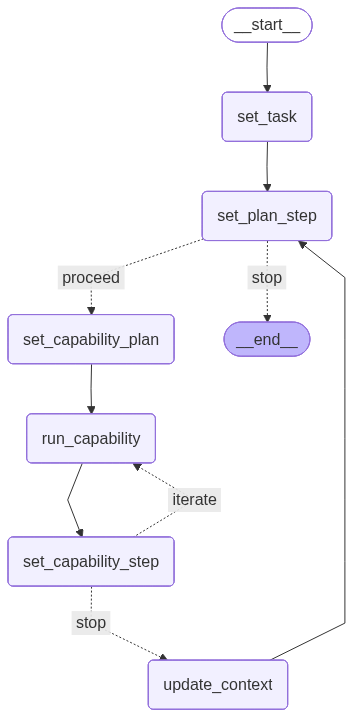

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor, AgentCapabilityCodeWritterExecutor
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


workflow = StateGraph(state_schema=ExecutionState)

def init_state(ask: str, resources: list[ContentResource] = list()) -> ExecutionState:
    # TODO: should I be using LLM to convert attachments/resources to acceptable format?
    # TODO: implement proper handling of attachments and resources 
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources,
    )

def set_task(state: ExecutionState) -> ExecutionState: 
    question_task = state["ask"]
    resources = state["resources"]
    task_plan_response = create_plan(question_task, resources)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    state["task"] = task

    return state

def set_plan_step(state: ExecutionState) -> ExecutionState: 
    """  
    Determine which state is being executed. 
    """
    if state["step"] is None: 
        state["step"] = 0 
    else:
        state["step"] += 1
         
    return state

def check_plan_completion(state: ExecutionState) -> str:
    # FIXME: delete me, see what to do with the showrt_anser var, now only for debugging?
    print("\nSHORT ANSWER:\n", construct_short_answer(state["task"].objective, state["context"]), "\n")
    
    # TODO: might incorporate early stopping if answer is found
    # if not short_answer | len(short_answer.answer) == 0 | short_answer.answer.lower() != "not found":
        
    plan_length = len(state["task"].plan)
    if state["step"] < plan_length:
        return "proceed"
    else:
        return "stop"

def set_capability_plan(state: ExecutionState) -> ExecutionState: 
    state["capability_plan"] = determine_capabilities(
        state["task"].plan[state["step"]], 
        task=state["task"], 
        resources=state["resources"],
        context=state["context"]
    )
    state["capability_plan_step"] = 0

    return state

def set_capability_step(state: ExecutionState) -> ExecutionState:
    if state["capability_plan_step"] is None:
        state["capability_plan_step"] = 0 
    else:
        state["capability_plan_step"] += 1 

    return state

def check_capability_step(state:ExecutionState) -> ExecutionState: 
    capability_plan_length = len(state["capability_plan"].subplan)
    if state["capability_plan_step"] < capability_plan_length:
        # run the next capability step
        return "iterate"        
    else: 
        # signal that we need to move over to the next state
        return "stop" 

def run_capability(state: ExecutionState) -> ExecutionState: 
    capability_agent = state["capability_plan"].subplan[state["capability_plan_step"]]
    output = None
    match capability_agent:
        case AgentCapabilityDeepWebSearch():
            output = capability_agent.run()
        case AgentCapabilityUnstructuredDataProcessor():
            output = capability_agent.run(state["resources"])
        case AgentCapabilityCodeWritterExecutor():
            output = capability_agent.run(state["resources"])
        case _:
            print("DEBUG | run_capability | Call to unidentified agent: ", capability_agent)
    answers = output.answers
    resources = output.resources

    if answers:
        state["answers"].extend(answers)
    if resources:
        state["resources"].extend(resources)

    return state

def update_context(state: ExecutionState) -> ExecutionState:
    asked = state["task"].plan[state["step"]]
    found = state['answers']
    context_delta = "\n" + str(
        {
            "asked": asked,
            "found": found,
        }
    ) 
    state["context"] += context_delta

    # # TODO: IMPORTANT need to save them somewhere else? 
    # state["resources"] = list()
    return state

FILE_NAME_SAVED_STATE = "state.pkl"
def save_state(state: ExecutionState):
    import pickle
    
    with open(FILE_NAME_SAVED_STATE, "wb") as f:
        pickle.dump(state, f)

def load_state(path: str = FILE_NAME_SAVED_STATE) -> ExecutionState:
    import pickle

    with open(path, "rb") as f:
        return pickle.load(f)

# Why: determine what we want to do and what we are given as input (e.g., some files)
workflow.add_node("set_task", set_task)
# Move over to producing an overarching plan: the steps of that plan you will follow one by one 
# Each step is a certain stage in getting to an asnwer. 
# E.g., plan = [Step1: searching internet for subquestion1; step2: search internet for an answer given answer to subquestion1 was YYY]
workflow.add_node("set_plan_step", set_plan_step)
# Answer to each step is determined by create a capabulity plan, i.e., which specialised agent(s) we would like to involve to get an answer. 
# a capability plan is dependent on the context (i.e., all the previous finds that we collected from previous steps)
workflow.add_node("set_capability_plan", set_capability_plan)
# Execute the capability plan one step at a time.
# For example, 1)capability_plan_step1: search web ; 2)capability_plan_step2: analyse whatever you found in previously  
workflow.add_node("run_capability", run_capability)
# Move over to the next capability_plan_step
workflow.add_node("set_capability_step", set_capability_step)
# When the capability plan is finished - summarise the results into the context 
# Context = list of all the answers to capability_plan execution=plan_step 's  
workflow.add_node("update_context", update_context)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "set_plan_step")
workflow.add_conditional_edges(
    "set_plan_step",
    check_plan_completion,
    {
        "proceed": "set_capability_plan",
        "stop": END,
    }
)
workflow.add_edge("set_capability_plan", "run_capability")
workflow.add_edge("run_capability", "set_capability_step")
workflow.add_conditional_edges(
    "set_capability_step", 
    check_capability_step,
    {
        "iterate":"run_capability",
        "stop": "update_context",
    }
)
workflow.add_edge("update_context", "set_plan_step")

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
# Test part nodes & logging
import logging

import mlflow

from generalist.models.core import MLFlowLLMWrapper
from generalist.utils import pprint
from generalist.tools import planning, web_search, text_processing, code

# STARTING TO LOG EVERYTHING (MANUALLY ADDED)
logging.getLogger().setLevel(logging.INFO)

mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
# MONKEY PATCH the llm call
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)
code.llm = MLFlowLLMWrapper(code.llm)

# FIXME: delete the if-statement, if wanting to test at this stage
if False: 
    question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."
    initial_state = init_state(question)

    state = set_task(initial_state)
    pprint(state["task"].__str__())

In [4]:
raise InterruptedError

InterruptedError: 

In [ ]:
# Test 1
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [ ]:
# Task 2 
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [ ]:
# Task 3
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "The attached Excel file contains the sales of menu items for a local fast-food chain. " \
"What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places."

sources = [
    ContentResource(
        provided_by="user", 
        content="", 
        link="/Users/maksim.rostov/pdev/freestyling/agents/hf-course/unit4_general_agent/generalist/notebooks/7bd855d8-463d-4ed5-93ca-5fe35145f733.xls",
        metadata={},
    )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

In [ ]:
# Task 4 : PDF 
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

# TODO: check if this task actually requires PDF processing 
question = "Where were the Vietnamese specimens described by Kuznetzov in Nedoshivina's 2010 paper eventually deposited? " \
"Just give me the city name without abbreviations."

sources = []
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

In [ ]:
# Task 5: search and Information Retrieval from just text 
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question =\
"""What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. 
Give the IOC country code as your answer."""

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [ ]:
# Task 6: python code execution  
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question =\
"""What is the final numeric output from the attached Python code?"""

sources = [
    ContentResource(
        provided_by="user", 
        content="", 
        link="/Users/maksim.rostov/pdev/freestyling/agents/hf-course/unit4_general_agent/generalist/notebooks/f918266a-b3e0-4914-865d-4faa564f1aef.py",
        metadata={},
    )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

In [5]:
# Task 7: loading video file, transcribing it.  
import logging

import mlflow

# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question =\
"""Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec. What does Teal'c say in response to the question "Isn't that hot?"""

sources = [
    ContentResource(
        provided_by="user", 
        content="", 
        link="https://www.youtube.com/watch?v=1htKBjuUWec",
        metadata={},
    )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

2025-10-22 17:10:37,005 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"
2025-10-22 17:10:54,202 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


🏃 View run qwen2.5:14b_create_plan at: http://localhost:5000/#/experiments/737920836275328806/runs/639ef399d1114448bf62da8d2137005c
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:10:59,658 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"



SHORT ANSWER:
 ShortAnswer(answer='not found', clarification="The provided list is empty, containing no information related to Teal'c's response or the question 'Isn't that hot?' in any YouTube video.") 



2025-10-22 17:11:14,155 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:11:14,263 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Watch the video at the given link to identify when the question is asked.",
      "capability": "code_writing_execution"
    },
    {
      "activity": "Identify and note down the timestamp or specific moment in the video where the question 'Isn't that hot?' is asked.",
      "capability": "unstructured_data_processing"
    }
  ]
}


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/ccb3f23d889649ee93aadeafbef3c29b
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:12:18,479 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:12:18,663 - generalist.agents.core - INFO - - AgentCapabilityCodeWritterExecutor.run -- EDA code to be executed:
To handle the resource provided, which is a YouTube video link, we will need to download it first and then process it accordingly. Given that YouTube videos are typically in MP4 format and contain audio tracks, we'll use libraries such as `youtube-dl` for downloading the video, and `moviepy` or `speech_recognition` with `pyttsx3` for processing the contents (transcribing audio).

Below is a Python script to download the YouTube video, transcribe its audio content, and extract metadata about the video file:

```python
import youtube_dl
from moviepy.editor import AudioFileClip

# Function to download a YouTube video using youtube-dl
def download_youtube_video(url):
    ydl_opts = {
        'format': 'bestaudio/best',  # Download the best audio quality ava

🏃 View run qwen2.5:14b_write_python_eda at: http://localhost:5000/#/experiments/737920836275328806/runs/22da226d667a41629b1af329ce220e1f
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:12:47,902 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:12:48,009 - generalist.agents.core - INFO - - AgentCapabilityCodeWritterExecutor.run -- Final code to be executed:
It seems like you're trying to extract information from a YouTube video by watching it. However, due to the `ModuleNotFoundError` for `youtube_dl`, we cannot directly use Python to watch videos or extract timestamps from them.

Instead, I will provide you with an example of how you can manually approach this task:

1. **Watch the Video**: Go to the provided link (`https://www.youtube.com/watch?v=1htKBjuUWec`) and watch the video.
2. **Identify the Question Time Stamp**: Note down when the specific question is asked.

Since `youtube_dl` cannot be used directly, you would need an alternative approach if automating this task:

- Use a web scraping library like Selenium to control a browser and extract the timestamp interactively.
- Manually note down tim

🏃 View run qwen2.5:14b_write_python_code_task at: http://localhost:5000/#/experiments/737920836275328806/runs/d215d421cf824eccb7dd9b9dd18996d6
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:12:53,904 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:13:00,113 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"



SHORT ANSWER:
 ShortAnswer(answer='not found', clarification="The provided list contains an error message about a missing Python module 'selenium', which is unrelated to watching any video or identifying Teal'c's response.") 



2025-10-22 17:13:14,613 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:13:14,729 - generalist.tools.planning - INFO - - determine_capabilities -- Raw output: {
  "subplan": [
    {
      "activity": "Download and watch the video to find Teal'c's exact response.",
      "capability": "code_writing_execution"
    },
    {
      "activity": "Transcribe the specific part of the video where Teal'c responds.",
      "capability": "audio_processing"
    }
  ]
}


🏃 View run qwen2.5:14b_determine_capabilities at: http://localhost:5000/#/experiments/737920836275328806/runs/2d250c2d5d174fd78150f4de62c64992
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:14:10,670 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:14:10,846 - generalist.agents.core - INFO - - AgentCapabilityCodeWritterExecutor.run -- EDA code to be executed:
To handle the YouTube video provided, we can use Python libraries such as `youtube_dl` to download the video and then use a library like `moviepy` or `speech_recognition` with `pydub` for audio processing and transcription.

Below is an example of how you might write this code:

```python
import youtube_dl
from moviepy.editor import AudioFileClip
import speech_recognition as sr

# Define the URL of the YouTube video
video_url = 'https://www.youtube.com/watch?v=1htKBjuUWec'

def download_video(url):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'quiet': True,
    }
    with youtube_dl

🏃 View run qwen2.5:14b_write_python_eda at: http://localhost:5000/#/experiments/737920836275328806/runs/20231451645a4405bcc4e30a55a12881
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:14:42,752 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-10-22 17:14:42,880 - generalist.agents.core - INFO - - AgentCapabilityCodeWritterExecutor.run -- Final code to be executed:
It looks like you're trying to download a YouTube video or extract information from it. However, based on the error message you've provided (`ModuleNotFoundError: No module named 'youtube_dl'`), it seems you are missing the `youtube-dl` package, which is typically used for downloading content from various websites including YouTube.

Firstly, you should install `youtube-dl`. You can do this by running:

```bash
pip install youtube-dl
```

After installing `youtube-dl`, you can use it in Python to download the video and then extract specific information, like Teal'c's response. However, scraping YouTube videos for content-specific details such as exact dialogue is complex and may not be feasible with simple scripts due to YouTube's API requirements and

🏃 View run qwen2.5:14b_write_python_code_task at: http://localhost:5000/#/experiments/737920836275328806/runs/b58f68c768d84006b29661b0cda76372
🧪 View experiment at: http://localhost:5000/#/experiments/737920836275328806


2025-10-22 17:14:49,749 - httpx - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


DEBUG | run_capability | Call to unidentified agent:  AgentCapabilityAudioProcessor(name='audio_processing', activity='Transcribe the specific part of the video where Teal'c responds.')


AttributeError: 'NoneType' object has no attribute 'answers'

Trace(trace_id=e7c5b11783b14b50a261f0367ba5dbd4)